# Problem set 4
## "A plague of sand mice"
### Zachary Miller

## Part 1: Showing that Moriarty's method is utterly useless

We are suspicious of Moriarty's claim that his classifier performs perfecty, so we decide to test it for ourselves on some labeled RNA sequences. First, we want to calculate the score using Moriarty's scoring method for each labeled sequence. To do so, we will read all the sequences from each FASTA file into lists. Then, we will plot the false positve rate vs the true positive rate for each value of the threshold to create a ROC plot. Additionally, let's plot a histogram of the score distributions for the pathogen and sand mouse sequences calculated using Moriarty's method to help us visualize how well his method differentiates the two.

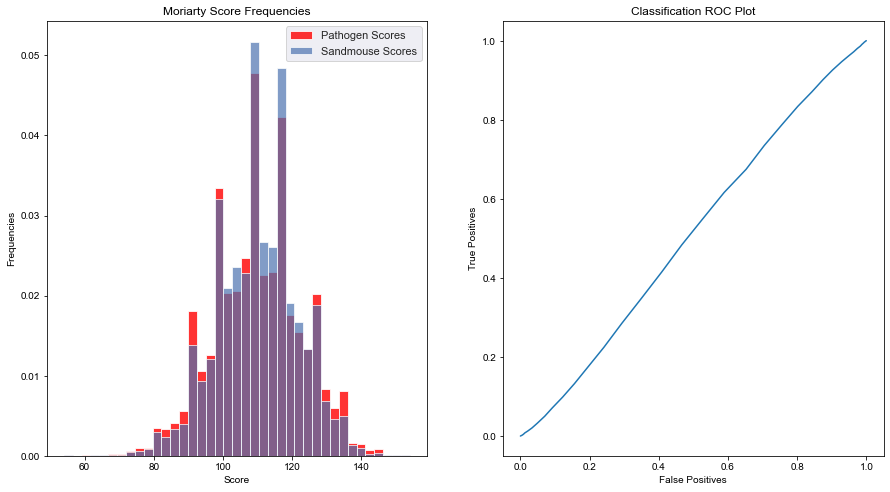

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools as it

%matplotlib inline

random.seed(42)

# Create some usefull functions

def moriarty_score(sequence):
    """Given a sequence, """
    score = 0
    for i in sequence:
        if i == "A" or i == "T":
            score += 1
            
        elif i == "G" or i=="C":
            score -= 1
            
    return score

def get_seqs_from_fasta(fasta_file):
    """Given a FASTA file, returns a list containing all of the sequences in the file"""
    seq_list = []
    file = open(fasta_file, "r")
    lines = file.readlines()
    lines = [i.rstrip("\n") for i in lines]
    last_line = lines[-1] 
    
    # Iterate over each line and add all the sequence lines for a given transcript to one string, then append that 
    # string to the sequence list
    s = ""
    for line in lines:
        reset = False
        if line[0] == ">":
            if len(s) == 0: continue
                
            else: 
                seq_list.append(s)
                s = ""
                
        elif line is last_line:
            s += last_line
            seq_list.append(s)
            
        else:
            s = s+line
        
    file.close()
    
    return seq_list

# Read in the sequences
path_seq_list = get_seqs_from_fasta("pathogen.fa")
sm_seq_list = get_seqs_from_fasta("sandmouse.fa")

# Get the scores using Moriarty's method for both sequences
moriarty_path_scores = []
moriarty_sm_scores = []

for seq in path_seq_list:
    moriarty_path_scores.append(moriarty_score(seq))
    
for seq in sm_seq_list:
    moriarty_sm_scores.append(moriarty_score(seq))

# Create a range of threshold values to try
mor_threshold_arr = np.linspace(min((min(moriarty_path_scores), min(moriarty_sm_scores))), 
                                max((max(moriarty_path_scores), max(moriarty_sm_scores))), num=1000)
mor_tp_list = []
mor_fp_list = []

# Iterate over all the threshold values
for threshold in mor_threshold_arr:
    temp_tp_list = []
    temp_fp_list = []
    
    # Add a 1 to the temporary true positive list for each correct classification of a positive at this threshold, 
    # and a 0 for a false one
    for score in moriarty_path_scores:
        if score > threshold: temp_tp_list.append(1)
        elif score <= threshold: temp_tp_list.append(0)
    # Add a 1 to the temporary false positive list for each incorrect classification of a negative at this threshold,
    # and a 0 for each correct one
    for score in moriarty_sm_scores:
        if score < threshold: temp_fp_list.append(0)
        elif score >= threshold: temp_fp_list.append(1)
            
    # Divide by the total number of positives or negatives to get the true positive and false postive rates, 
    # respectivly
    mor_tp_list.append(sum(temp_tp_list)/len(moriarty_path_scores))
    mor_fp_list.append(sum(temp_fp_list)/len(moriarty_sm_scores))
    
    
# Plot the Moriarty score histograms and the ROC plot
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
sns.set()
mor_bins = np.linspace(min((min(moriarty_path_scores), min(moriarty_sm_scores))), 
                       max((max(moriarty_path_scores), max(moriarty_sm_scores))), 40)

ax1.hist(moriarty_path_scores, bins=mor_bins, color = "red", label="Pathogen Scores",
         alpha = 0.8, density=True)

ax1.hist(moriarty_sm_scores, bins=mor_bins, color = "b", label="Sandmouse Scores", 
         alpha=0.7, density=True)

ax1.set_title("Moriarty Score Frequencies")
ax1.set_xlabel("Score")
ax1.set_ylabel("Frequencies")
ax1.legend()

ax2.plot(mor_tp_list, mor_fp_list)
ax2.set_title("Classification ROC Plot")
ax2.set_xlabel("False Positives")
ax2.set_ylabel("True Positives")

plt.show()


Looking at the resulting histogram and ROC plot, we can see that Moriarty's method does not work well at all on real data. For the ROC plot, we can see that the curve is very close to being the line $y=x$, which means that Moriarty's method only performs ever-so-slightly better than chance for some threshold vlaues. Looking at the histogram, we can tell the the ROC plot makes intuitive sense because the score distributions for the sand mouse and pathogen scores are almost identical (purple indicates overlap in the histogram). The most likely reason for this is that real DNA sequences have sequence motifs that are not uniformly random. For example, in a perfectly random sequence all letters are equally likely to appear, but in both the sand mouse and pathogen sequences, A and T occur much more frequently than C and G, so it is easy to tell them apart from random sequences by simply counting the number of occurences for each letter (which is basically what Moriarty's method does).

## Part 2: Further establishing our dominance by making a classifier that actually works

After having embarrassed Moriarty in front of our PI, we are now asked to impliment a second order Markov model which we will use to classify a given sequence as being from the mouse or from the pathogen, with the hope that this model will help us catch the non-uniform sequence motifs mentioned above. In a second order Markov model, we assume that each letter in the sequence is dependent on the two preceeding letters, and therefore $P(x_i|x_{i-1},x_{i-2})$. Since the first two nucleotides of our sequence do not have two proceeding nucleotides, we will assume that their probabilities are conditionally independent, but not unconditionally independent from eachother, and are therefore given by $P(x_1,x_2)$. Assuming that the probability of any given nucelotide is not dependent on the position of that nucleotide (except for the first two), we now have an expression for the likelyhood of any given sequence of length $L$: $$P(x_1,...,x_L)=P(x_1,x_2)\prod_{i=3}^{L}P(x_i|x_{i-1},x_{i-2})$$ Where $x_i$ is the ith nucelotide in the sequence. 

In order to impliment this model, we will first have to estimate all the relevant probabilities. To do so, we will start by using the maximum likelyhood estimate $\hat{p}$ to estimate the probability of any length 3 substring being a particular sequence. Consider all the possible length 3 substrings within a given DNA sequence, which we will denote as $n$. For any length 3 sequence of interest $s$, we can check $s$ against all of the possible length 3 substrings in the sequence, considering each test as a "trial". Each time the string matches, we will consider it a "succcessful" trial, and each time it does not match we will consider it a "failed" trial. This is exactly the situation that the binomial distribution describes (given a few mild assumptions). With a little bit of work, it can be shown that the best estimate $\hat{p}$ for the true probability of a given length 3 substring mathcing $s$ is simply the number of "successful" trials over n, or the frequency with which s occurs in the main sequence. 

Once we have calculated our probability estimates for all possible length 3 substrings $s$, we can use these probabilities $P(x_{i-2}, x_{i-1}, x_{i})$ to find the conditional probabilities $P(x_i|x_{i-1},x_{i-2})$ by re-writing 
$$P(x_i|x_{i-1},x_{i-2}) = \frac{P(x_{i-2}, x_{i-1}, x_{i})}{P(x_{i-1}, x_{i-2})} = \frac{P(x_{i-2}, x_{i-1}, x_{i})}{\sum_{x_i\in(A,G,T,C)}P(x_{i-2}, x_{i-1}, x_{i})}$$

In order to obtain our estimates for all of the conditional probabilities, we will have to split the labeled sequence data into training data (to obtain our estimates), and testing data (to test the perfformance of our classifier using our estimates). Once we have split the data, we will iterate over all the possible substrings and get the relevant counts for each, and then calculate the condional probabilities according to the equation above. Note that we could write our code such that we just skip directly to the last equation, gather the relevant frequencies, and then calculate the conditional probabilities direclty (which would be more computationally efficient). I chose instead, however, to do this two step proccess because it makes for much easier debugging, and therefore it will be easier to find/fix issues with our code and less likely that an error will go unnoticed.

Lastly, we will have to calculate our estimates for the probabilities of the first two starting letters. For these, we will consider the probabilities to be dependent on the location of the sequence in the string (so in this case the probability of a given two letter string showing up at the beggining of a sequence is different than it showing up elsewhere in the sequence). This way, we will be able to catch details that would otherwise go unnoticed (like all of the pathogen sequences being much more likly to start with a specific two letter substring, etc.) Also, since we have 5,000 training sequences for each, the estimates will be very close to the estimates we would get if we used all the occurences if the occurences are location independent anyway. To calcuate our probability estimate, we will simply use the occurence frequency of occurences at the start of a sequence for each possible two letter substring.

In [2]:
def tt_data_split(data, split):
    """Given a list of data and a number between 0 and 1, splits the data into testing and training data according
    to the portion given by split, where the number split gives the portion of training data"""
    
    split_num = int(round(len(data)*split))
    random.shuffle(data) # shuffle the data to ensure randomness
    
    train_data = data[:split_num]
    test_data = data[split_num:]
    
    return train_data, test_data

def create_occurence_lists(seq_list):
    """ Given a list of sequences, return an occurence list for each nucleotide letter. Each occurance list should
    be a list of n 3 character strings, where each 3 character string ends in the nucleotide letter the list 
    cooresponds to and includes the two preceding letters in the seqeunce. Note that this function is not for general
    use"""
    nuc_list = ["A", "G", "T", "C"]
    A_occ_list = []
    G_occ_list = []
    T_occ_list = []
    C_occ_list = []

    # Iterate over each possible nucleotide letter
    for letter in nuc_list:
        temp_occ_list = []
        # Iterate over each sequence in the training sequences
        for seq in seq_list:
            # Iterate over each character in the sequence (starting at the 3rd character)
            for idx, c in enumerate(seq[2:]):
                # If the character matches the current nucleotide letter, add it and it's two preceding characters to
                # the temporary occurence list
                if c == letter:
                    temp_occ_list.append(seq[idx:idx+3])

        # Assign the proper nucleotide occurance list to the temporary occurance list
        if letter == "A": A_occ_list = temp_occ_list
        if letter == "G": G_occ_list = temp_occ_list
        if letter == "T": T_occ_list = temp_occ_list
        if letter == "C": C_occ_list = temp_occ_list

    return [np.asarray(A_occ_list), np.asarray(G_occ_list), np.asarray(T_occ_list), np.asarray(C_occ_list)]

def create_seq_probs_dict(occs_list):
    """Given a list of sequence occurences, creates a dict of probabilities for each possible 3rd character given 
    the first two characters. Note that this function is not for general use"""
    
    total_occs = sum([len(i) for i in occs_list])
    unique_occs_list = []

    for i in occs_list:
        unique_seqs, unique_seq_counts = np.unique(i, return_counts=True)
        unique_seq_probs = unique_seq_counts/total_occs
        uniques_for_dict = np.vstack((unique_seqs, unique_seq_probs))
        unique_occs_list.append(uniques_for_dict)

    unique_occs = np.hstack(unique_occs_list)
    seq_probs = dict(zip(unique_occs[0], [float(i) for i in unique_occs[1]]))
    
    cond_probs_for_dict = []
    # Get all possible combinations of 2 letters from AGTC
    letter_combs = it.product("AGTC", repeat=2)  
    # Iterate over each letter combination
    for seq in letter_combs:
        temp_list = []
        # Iterate over all the sequences, and add the key:value combination to a temporary list if the first two 
        # letters match the current letter combo sequence
        for key in seq_probs:
            if key[0:2] == "".join(seq):
                temp_list.append([key, seq_probs[key]])
                
        # Get the total occurence frequency (probability) for all keys starting with the current letter combo\
        # sequence
        total_prob = sum([i[1] for i in temp_list])
        # Normalize the probability to get the conditional probability, then add it to the conditional probabilities
        # for dictionary list as a tuple of the form (key, conditional_probability)
        for idx, element in enumerate(temp_list):
            cond_probs_for_dict.append((element[0], element[1]/total_prob))
            
    # Create the conditional probabilities dict from the conditional probabilities list
    cond_seq_probs = {}
    cond_seq_probs.update(cond_probs_for_dict)
            
    return cond_seq_probs

def create_start_seq_probs_dict(seq_list):
    """Iterates over each sequence and calculate the frequency of each possible length 2 start sequence"""
    letter_combs = it.product("AGTC", repeat=2)
    start_seq_probs_for_dict = []
    for comb in letter_combs:
        seq_count = 0
        comb_seq = "".join(comb)
        for seq in seq_list:
            if seq[0:2] == comb_seq:
                seq_count += 1
        start_seq_probs_for_dict.append((comb_seq, seq_count/len(seq_list)))
        
    start_seq_probs = {}
    start_seq_probs.update(start_seq_probs_for_dict)
    
    return start_seq_probs

# Split the labeled sequences into testing and training data
path_train_seq_list, path_test_seq_list = tt_data_split(path_seq_list, 0.5)
sm_train_seq_list, sm_test_seq_list = tt_data_split(sm_seq_list, 0.5)

# Create lists for each occurence of A, G, T, or C, along with the two proceeding letters
path_occs_list = create_occurence_lists(path_train_seq_list)
sm_occs_list = create_occurence_lists(sm_train_seq_list)

# Use those lists to create a dict of occurence frequencies for each 3 letter sequence
path_cond_seq_probs = create_seq_probs_dict(path_occs_list)
sm_cond_seq_probs = create_seq_probs_dict(sm_occs_list)

# Calculate the start sequence probability estimates
path_start_seq_probs = create_start_seq_probs_dict(path_train_seq_list)
sm_start_seq_probs = create_start_seq_probs_dict(sm_train_seq_list)


In [9]:
sm_cond_seq_probs

{'AAA': 0.3857929240865388,
 'AAG': 0.1126944663419104,
 'AAT': 0.3886766519111435,
 'AAC': 0.11283595766040737,
 'AGA': 0.3861698399719659,
 'AGG': 0.11103843008994277,
 'AGT': 0.38775843943464555,
 'AGC': 0.11503329050344588,
 'ATA': 0.3890285683636046,
 'ATG': 0.1127112791734551,
 'ATT': 0.3855689871338442,
 'ATC': 0.11269116532909602,
 'ACA': 0.3893345699049385,
 'ACG': 0.11073498724785531,
 'ACT': 0.3851379550197078,
 'ACC': 0.11479248782749824,
 'GAA': 0.38963191186424856,
 'GAG': 0.11236374670307869,
 'GAT': 0.38620077959059823,
 'GAC': 0.11180356184207456,
 'GGA': 0.39164767176815374,
 'GGG': 0.110875936177141,
 'GGT': 0.38391403451644424,
 'GGC': 0.11356235753826116,
 'GTA': 0.3865495304453196,
 'GTG': 0.11054925080977793,
 'GTT': 0.3888565236641577,
 'GTC': 0.11404469508074476,
 'GCA': 0.3875809764575763,
 'GCG': 0.11123400221203981,
 'GCT': 0.3903460262284721,
 'GCC': 0.11083899510191184,
 'TAA': 0.38823868898224323,
 'TAG': 0.11072114029554267,
 'TAT': 0.3887218650596588,
 

In [8]:
sum({'AAA': 0.4722737448033259,
 'AAG': 0.07144227694275664,
 'AAT': 0.347649504317237,
 'AAC': 0.10863447393668053}.values())

1.0

Now we have a dict containing our probability estimates for both the start sequences and the length 3 substring sequences. We can now use these estimates to calculate the probability of any string according to our second-order Markov model. 

Next, we want to write a script that will allow us to take a sequence and classify it as being from either a pathogen or a sand mouse. To do this, we will take the log of the ratio of the likelyhood scores for the sequence under the assumption that it is from a pathogen (using the parameters estimated for the pathogen) and under the assumtion that it is from a sandmouse (using the paramters estimated for the sand mouse). The sign of the resulting number will tell us if the sequence is more likely to be from a pathogen (postive sign) or a sand mouse (negative sign) according to our model.

Once we have calculated the log-likelyhood ratio for each sequence in our test sequences, we will calcuate and plot all of the same measures that we did for Moriarty's classifier.

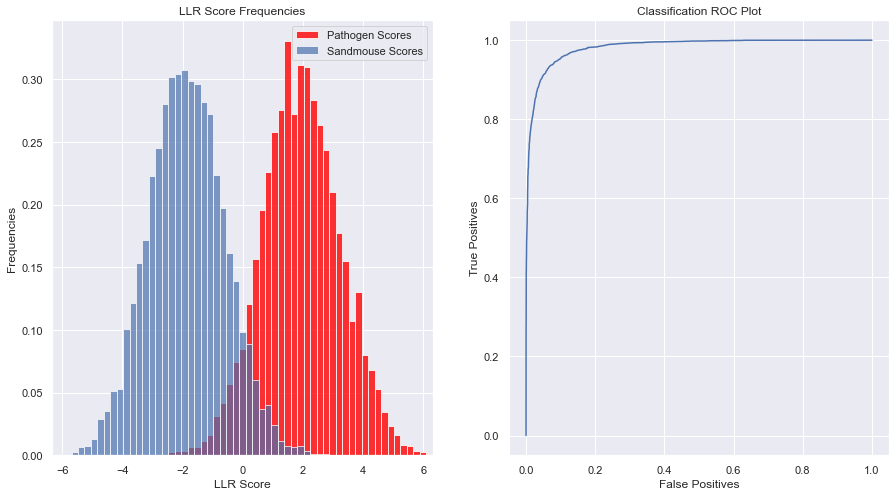

In [3]:
def get_llh_of_seq(test_seq, cond_probs, start_probs):
    """Given a test sequence of DNA (as a string) and the conditional and start probabilities (as dicts) of each 
    possible sequence for a second order markov model, calculates the log likelyhood that the test sequence came 
    from a distribution with those start and conditional probabilities"""
    log_product_factors_list = []
    log_product_factors_list.append(start_probs[test_seq[:2]])
    
    for idx, c in enumerate(test_seq[2:]):
        log_product_factors_list.append(np.log10(cond_probs[test_seq[idx:idx+3]]))
        
    return sum(log_product_factors_list)

def get_llr_list(seq_list, cond_probs_1, cond_probs_2, start_probs_1, start_probs_2):
    """Given a list of sequences and two parameter sets for a 2nd order Markov model, returns a list of all the
    log-likelyhood ratios. Noe that this funcion is not for general use"""
    llr_list = []
    for seq in seq_list:
        llh_1 = get_llh_of_seq(seq, cond_probs_1, start_probs_1)
        llh_2 = get_llh_of_seq(seq, cond_probs_2, start_probs_2)
        llr_list.append(llh_1-llh_2)
    
    return np.asarray(llr_list)
    
path_llr_arr = get_llr_list(path_test_seq_list, path_cond_seq_probs, sm_cond_seq_probs,
                            path_start_seq_probs, sm_start_seq_probs)

sm_llr_arr = get_llr_list(sm_test_seq_list, path_cond_seq_probs, sm_cond_seq_probs,
                          path_start_seq_probs, sm_start_seq_probs)


tp_list = []
fp_list = []
# Get a range of 100 threshold values to test from the min llr to the max llr
threshold_arr = np.linspace(min((min(path_llr_arr), min(sm_llr_arr))), max((max(path_llr_arr), max(sm_llr_arr))),
                            num=1000)

# Iterate over each threshold value
for threshold in threshold_arr:
    temp_tp_list = []
    temp_fp_list = []
    # Add a 1 to the temporary true positive list for each correct classification of a positive at this threshold, 
    # and a 0 for a false one
    for score in path_llr_arr:
        if score > threshold: temp_tp_list.append(1)
        elif score <= threshold: temp_tp_list.append(0)
    # Add a 1 to the temporary false positive list for each incorrect classification of a negative at this 
    # threshold, and a 0 for each correct one
    for score in sm_llr_arr:
        if score < threshold: temp_fp_list.append(0)
        elif score >= threshold: temp_fp_list.append(1)
    # Divide by the total number of positives or negatives to get the true positive and false postive rates, 
    # respectivly
    tp_list.append(sum(temp_tp_list)/len(path_llr_arr))
    fp_list.append(sum(temp_fp_list)/len(sm_llr_arr))

    
# Create the score histogram and the ROC plot
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
sns.set()
bins = np.linspace(min((min(path_llr_arr), min(sm_llr_arr))), max((max(path_llr_arr), max(sm_llr_arr))), 60)
ax1.hist(path_llr_arr, bins, color = "red", label="Pathogen Scores",
                alpha = 0.8, density=True)
ax1.hist(sm_llr_arr, bins, color = "b", label="Sandmouse Scores", 
         alpha=0.7, density=True)
ax1.set_title("LLR Score Frequencies")
ax1.set_xlabel("LLR Score")
ax1.set_ylabel("Frequencies")
ax1.set_xlim([min((min(path_llr_arr), min(sm_llr_arr))), max((max(path_llr_arr), max(sm_llr_arr)))])
ax1.legend()

ax2.plot(fp_list, tp_list)
ax2.set_title("Classification ROC Plot")
ax2.set_xlabel("False Positives")
ax2.set_ylabel("True Positives")

plt.show()

Looking at the plots, we can see that this calssifier works much better than Moriarty's classifier, and actually works quite well in general. The ROC plot is very bowed outwards, which means that we are classifiying at a much better rate than chance. Looking at the histogram, it is easy to see why. The distributions for the pathogen LLR scores and the sand mouse LLR scores are obviously quite different, which means that we should be able to tell with a fairly high probability which distribution a given sequence came from based on its score. Still, there is a fair amount of overlap between the two, which means that some sequences give LLR scores for which it is somewhat ambiguos as to which ditriibution it was drawn from.

## Part 3: Checking how well our classifier works so we don't get rekt by an undergrad showing that our classifier is actually garbage like we did to Moriarty

Now we are told that the lab needs our classifier to obtain at least 90% sensitivity to be useful, and we are asked to find the threshold that produces that level of sensitivity while minimizing the false positive rate. We do so below

In [4]:
idx_list = []
for idx, sens in enumerate(tp_list):
    if sens >= 0.9:
        idx_list.append(idx)

print("Optimal threshold: " + str(threshold_arr[max(idx_list)]))
print("False postive rate estimate at optimal threshold: " + str(fp_list[max(idx_list)]))
print("Sensitivity at optimal threshold: " + str(tp_list[max(idx_list)]))

Optimal threshold: 0.20958622886444989
False postive rate estimate at optimal threshold: 0.0524
Sensitivity at optimal threshold: 0.9006


We see that our optimal threshold is approximately 0.21. At this threshold, we obtain a false positive rate of about 0.0524. We are now asked to find the proportion of reads labeled pathogen that are actually from sand mice. Notice that another way of asking this is "given that a sequence is marked as being from a pathogen, what is the probability that is from a sand mouse?" Now we are in the language of conditional probability, and we can use Bayes Law to write:
$$P(S|L) = \frac{P(L|S)P(S)}{P(L)}$$
where S is the event that a given sequence is actually from a sandmouse and L is the probability that a sequence is labeled as a pathogen. We are told that $P(S)=0.99$, we know that $P(L|S) = 0.0524$ from our false positive rate, and we can use the law of total probability to find $P(L) = P(L|S)P(S)+P(L|P)P(P)$, where P is the event that the sequence is actually from a pathogen. $P(L|P)=0.9006$ as it is just the true positive rate, and we are told that $P(P)=0.01$. Plugging in, we get:
$$P(S|L) = \frac{(0.0524)(0.99)}{(0.0524)(0.99)+(0.9006)(0.01)} \approx 0.85$$

Therefore, we have a false discovery rate of approximately 0.85, which is not great. However, if we are more concerned with correctly identifying pathogen sequences that we are with falsely identifying sand mouse sequences as pathogen seqeuences, then this may not be too much of a concern.